# first implementation, the goal will be to adapt so it fits to a river implementation.

Notes sur la lecture de l'article :
- ce modèle complète d'autres modèles (ALMID -> CALMID)

questions sur le papier (trouvable en allant voir les autres papiers)
- utilisation du ADWIN (de ce que je vois, soit ils en font un soit ils font des updates avec 0 si bonne pred ou 1 si mauvaise pred) <-- ce que je fais pour l'instant
- training en utilisant les weights --> comment ça marche ? réponse pour l'instant : tirer une poisson et entrainer x fois selon le résultat
- quelle stratégie pour trouver le worst_clf ? jsp

river implementation ideas
- class inheritance for EnsembleClassifier

In [7]:
from river import drift
from river.tree import HoeffdingTreeClassifier
from tqdm import tqdm
from river.base import WrapperEnsemble, Classifier
from math import ceil, exp, log
from river import utils
import random
import collections

In [8]:
class LIFO:
    """simple Last In First Out queue
    """
    def __init__(self, max_size: int):
        self.max_size = max_size
        self.queue = []
        
        
    def __len__(self):
        return len(self.queue)
    
    
    def __iter__(self):
        return self

    def add(self, item):
        self.queue.append(item)
        if len(self.queue) > self.max_size:
            self.queue.pop(0)
            
            
    def count(self, x):
        return self.queue.count(x)

In [55]:
class CALMID(WrapperEnsemble, Classifier):
    
    def __init__(
        self,
        n_classes: int,
        model: Classifier = HoeffdingTreeClassifier(),
        n_models: int = 10,
        theta: float = 0.1,
        step_size: float = 0.1,
        epsilon: float = 0.1,
        budget: float = 0.5,
        sizelab: int = 1000,
        seed: int | None = None,
        ) -> None:
        """CALMID class constructor"""
        
        if budget <= epsilon:
            raise ValueError("budget must be greater than epsilon")
        if not 0 <= epsilon <= 1:
            raise ValueError("epsilon must be between 0 and 1")
        
        super().__init__(model, n_models, seed)
        
        # attrs from init values
        self.n_models = n_models
        self.theta = theta
        self.step_size = step_size
        self.epsilon = epsilon
        self.budget = budget
        self.sizelab = sizelab

        self.n_classes = n_classes # can we do better ? can we adapt ? can we add classes along the stream ? --> will have to update amt_matrix. maybe it can be our contribution !!
        
        # attrs with default values
        self.time_step = 0
        self.learning_step = 0
        self.learnt_classes = 0
        self.label_to_index = {}
        
        # attrs built from other attrs
        self.sizesam = ceil(self.sizelab*self.epsilon/self.n_classes) 
        self.label_queue = LIFO(max_size=self.sizelab)
        self.learning_queues = [LIFO(max_size=self.sizesam) for _ in range(self.n_classes)]
        # amt = asymetric margin threshold
        self.amt_matrix = [[self.theta for _ in range(self.n_classes)] for _ in range(self.n_classes)] 
        self._drift_detectors = [drift.ADWIN() for _ in range(self.n_models)]

    def predict_proba_one(self, x, **kwargs):
        """Averages the predictions of each classifier."""

        y_pred = collections.Counter()
        for model in self:
            y_pred.update(model.predict_proba_one(x, **kwargs))
        total = sum(y_pred.values())
        if total > 0:
            return {label: proba / total for label, proba in y_pred.items()}
        return y_pred
    
    def learn_one(self, x, y): 
        self.time_step += 1
        labelling = False
        zeta = random.uniform(0, 1)
        
        if self.time_step < self.sizelab or zeta < self.epsilon:
            self.label_queue.add(y)
            labelling = True
            
        elif self.uncertainty_selective_strategy(x, y) and self.learning_step / self.time_step < self.budget:
            self.label_queue.add(None)
            labelling = True
            
        else:
            self.label_queue.add(None)
        
        if labelling:
            if y not in self.label_to_index:
                self.label_to_index[y] = len(self.label_to_index)
                    
            self.learning_step += 1
            change_detected = False
            
            w = self.compute_weight(x, y)
            
            self.learning_queues[self.label_to_index[y]].add((x, y, w, self.time_step))
            
            # this is from river/ensemble/bagging.py
            for i, model in enumerate(self): # will it work ?
                for _ in range(utils.random.poisson(w, self._rng)):
                    model.learn_one(x, y)
                    self.learnt_classes = len(self.label_to_index)
            
                y_pred = model.predict_one(x)
                # try to understand this step, what is estimation ?
                error_estimation = self._drift_detectors[i].estimation
                self._drift_detectors[i].update(int(y_pred == y))
                if self._drift_detectors[i].drift_detected:
                    if self._drift_detectors[i].estimation > error_estimation:
                        change_detected = True

            if change_detected:
                max_error_idx = max(
                    range(len(self._drift_detectors)),
                    key=lambda j: self._drift_detectors[j].estimation,
                )
                self.models[max_error_idx] = self.initalize_base_classifiers()
                self._drift_detectors[max_error_idx] = drift.ADWIN()
                
                
    def uncertainty_selective_strategy(self, x, y) -> bool:
        labelling = False
        margin, yc1, yc2 = self.compute_probability_margin_and_top_classes(x)
        if margin <= self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]]:
            labelling = True
            imb_y = self.compute_imbalance(y)
            if y == yc1:
                self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]] *= (1 - self.step_size)
                if imb_y > 0.5:
                    self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]] *= (1 - self.step_size)
            elif y == yc2 and imb_y > 0.5:
                self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]] *= (1 - self.step_size)
        else:
            sampbudget = self.budget - self.learning_step / self.time_step
            q = margin - self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]]
            sampbudget = sampbudget / (sampbudget + q)
            zeta = random.uniform(0, 1)
            if zeta < sampbudget:
                labelling = True
            if labelling and y == yc2:
                self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]] = max([self.theta, self.amt_matrix[self.label_to_index[yc1]][self.label_to_index[yc2]]*(1 +self.step_size)])
        return labelling
    
    
    def compute_sample_difficulty(self, x, y) -> float:
        margin, yc1, yc2 = self.compute_probability_margin_and_top_classes(x)
        if yc1 == y:
            tf, s = 1, 0
        elif yc2 == y:
            tf, s = -1, 1
        else:
            tf, s = -1, 0
        return (1 - tf * margin) * exp(1 - tf - s)
    
    
    def compute_weight(self, x, y) -> float:
        imb_y = max(1, self.compute_imbalance(y))
        return log(1 + self.compute_sample_difficulty(x, y) + 1/imb_y)
    
    
    def compute_imbalance(self, y) -> float:
        return self.label_queue.count(y) / ((len(self.label_queue) - self.label_queue.count(None)) /self.n_classes)
    
    
    def compute_probability_margin_and_top_classes(self, x) -> float:
        if self.learnt_classes < 2:
            return 0, None, None
        predictive_probas = self.predict_proba_one(x)
        sorted_elements = sorted(list(predictive_probas.items()), key=lambda x: x[1], reverse=True)
        yc1, p_yc1 = sorted_elements[0]
        yc2, p_yc2 = sorted_elements[1]
        return p_yc1 - p_yc2, yc1, yc2
    
    
    def initalize_base_classifiers(self):
        model = self.model.clone()
        sample_sequence = []
        for i in range(self.n_classes):
            for sample in self.learning_queues[i]:
                sample_sequence.append(sample)
        sorted_sample_sequence = sorted(sample_sequence, key=lambda x: x[3]) # sort by timestamp
        for sample_x, sample_y, sample_weight, sample_arriving_time in sorted_sample_sequence:
            decay_factor = self.compute_decay_factor(sample_arriving_time)
            decayed_weight = decay_factor * sample_weight
            w = utils.random.poisson(decayed_weight)
            for _ in range(utils.random.poisson(w, self._rng)):
                model.learn_one(sample_x, sample_y)
        return model
            
            
    def compute_decay_factor(self, arriving_time):
        return exp(-(self.time_step - arriving_time) / self.sizelab)
        

In [56]:
from river import datasets
dataset = datasets.Insects(variant="incremental_imbalanced")
stream = iter(dataset)

In [57]:
calmid = CALMID(
    n_classes=dataset.n_classes,
)

label_to_id = {}
res = []
for i, (x, y) in tqdm(enumerate(stream)):
    y_hat = calmid.predict_one(x)
    calmid.learn_one(x, y)
    res.append(y_hat == y)

4397it [00:12, 339.78it/s] 


TypeError: 'LIFO' object is not iterable

<Axes: >

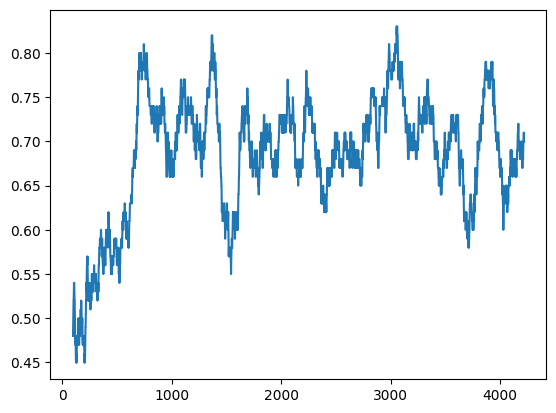

In [ ]:
import pandas as pd
pd.Series(res).rolling(100).mean().plot()

In [17]:
pd.Series(res).rolling(100)

Rolling [window=100,center=False,axis=0,method=single]


In [6]:
from river.tree import HoeffdingTreeClassifier
clf = HoeffdingTreeClassifier()
for (x, y) in stream:
    y_hat = clf.predict_one(x)
    print(y_hat)
    clf.learn_one(x, y)
    

None
cx-quinq-female
cx-quinq-female
cx-quinq-female
cx-quinq-female
cx-quinq-male
cx-quinq-female
ae-aegypti-female
ae-aegypti-female
ae-aegypti-female
ae-aegypti-female
cx-quinq-male
cx-quinq-male
cx-quinq-female
cx-quinq-male
ae-aegypti-female
ae-aegypti-female
cx-quinq-male
cx-quinq-female
ae-aegypti-female
cx-quinq-female
cx-quinq-female
ae-aegypti-female
cx-quinq-male
cx-quinq-female
cx-quinq-male
ae-albopictus-male
ae-albopictus-male
ae-albopictus-female
ae-aegypti-female
cx-quinq-male
ae-aegypti-female
cx-quinq-female
ae-aegypti-female
cx-quinq-female
ae-aegypti-female
cx-quinq-male
cx-quinq-male
ae-aegypti-female
cx-quinq-male
cx-quinq-male
ae-aegypti-female
ae-albopictus-male
cx-quinq-male
cx-quinq-male
ae-aegypti-female
ae-albopictus-male
cx-quinq-female
cx-quinq-male
cx-quinq-female
cx-quinq-male
cx-quinq-male
ae-albopictus-female
ae-albopictus-female
cx-quinq-male
cx-quinq-male
ae-aegypti-female
ae-albopictus-female
ae-aegypti-female
cx-quinq-male
cx-quinq-male
cx-quinq-ma

KeyboardInterrupt: 